In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import numpy as np
import torchvision
import matplotlib.pyplot as plt

from model import SetTransformer

key = jr.key(0)

In [2]:
def image_to_point_cloud(
    img,
    Npix=28,                # size of image
    Nextra=3,               # number of extra points to add
    noise_scale=0.5,        # Units of pixels
    plot=False,
    n_points_subsample=400, # Number of total points to subsample
):
    """ Convert image tensor to point cloud """
    rotation = np.array([[0.0, -1.0], [1.0, 0.0]]) # 90 deg rotation

    def pixel_to_coords(img, i, j, Nextra=Nextra):
        pixel_points = []

        # cartesian coordinates of pixel
        x = i 
        y = j

        # perturb position of point so img doesn't look gridded
        point = np.array([x, y])
        pixel_point = point + np.random.normal(loc=0.0, scale=noise_scale, size=(2,))

        pixel_points.append(pixel_point)

        # add some extra points for each pixel
        for i in range(Nextra):
            pixel_points.append(
                # add a few noisy points around the given point
                point + np.random.normal(loc=0.0, scale=noise_scale, size=(2,))
            )
        return pixel_points

    points = []  # (x, y) coordinates
    density = [] # pixel values
    for i in range(Npix):
        for j in range(Npix):
            # skip the empty pixels
            if img[i, j] == 0.:
                continue
            else:
                # make the (x,y) points for each pixel
                points.append(pixel_to_coords(img, i, j))
                # copy the pixel value accordingly
                density.extend([img[i, j]] * (Nextra + 1))

    density = np.asarray(density)
    points = np.asarray(points).reshape(-1, 2)
    points = np.matmul(points, rotation)

    # Scale points to [-1, 1]
    points = 2. * (points - points.min(axis=0)) / (points.max(axis=0) - points.min(axis=0)) - 1.

    if n_points_subsample is not None:
        idx = np.random.randint(0, len(points), size=(n_points_subsample,))
        points = points[idx]
        density = density[idx]

    if plot:
        cmap = "gray_r"
        plt.close()
        fig, ax = plt.subplots(1, 2, figsize=(4., 2.), dpi=200)
        print("POINTS", points.shape)
        ax[0].scatter(*points.T, c=density, s=5.0, cmap=cmap)
        ax[1].axis("off")
        ax[1].imshow(img, cmap=cmap)
        ax[0].axis("off")
        plt.show()

    return points, density

POINTS (1000, 2)


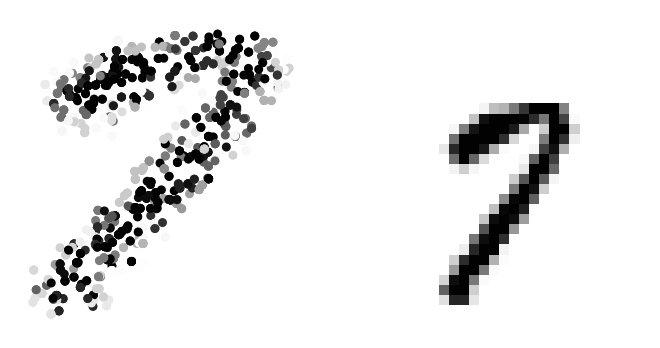

In [3]:
dataset = torchvision.datasets.MNIST(
    root="~/MNIST",
    download=True,
    transform=torchvision.transforms.ToTensor()
)

n_data = 10_000 # Max = 60,000
use_density = False

mnist_clouds = []
labels = []
for i in range(n_data):
    data = dataset[i]
    image, y = data

    points, density = image_to_point_cloud(
        image.numpy().squeeze(), # Remove channel --> numpy array
        plot=i == (n_data - 1), 
        n_points_subsample=1000
    )

    # Record the (x, y) points and the pixel density, plus label
    mnist_clouds.append(
        np.concatenate([points, density[:, np.newaxis]], axis=1)
        if use_density else points
    )
    labels.append(y) # Do this on the side to avoid type casting

In [4]:
# Stack as arrays, assuming sets of equal cardinality here
X = jnp.stack(mnist_clouds)
Y = jnp.stack(labels) # Optax wants integers for loss

X = (X - X.mean(axis=0)) / X.std(axis=0)

X.shape, Y.shape

((10000, 1000, 2), (10000,))

In [5]:
import optax 
from tqdm.notebook import trange

n_steps = 1000
n_batch = 128
opt = optax.adam(learning_rate=1e-4)

n_data, n_set, data_dim = X.shape

model = SetTransformer(
    data_dim, 
    out_dim=10, # MNIST
    n_layers=2, 
    n_heads=2, # Divisible by data_dim?
    n_seeds=100, 
    hidden_dim=64,
    embed_dim=None,
    key=key
)

opt_state = opt.init(eqx.filter(model, eqx.is_array))

def loss(model, x, y):
    y_ = jax.vmap(model)(x)
    return optax.softmax_cross_entropy_with_integer_labels(y_, y).mean()

@eqx.filter_jit
def make_step(model, opt_state, x, y):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value

losses = []
with trange(n_steps) as bar:
    for i in bar:
        ix = jr.randint(jr.fold_in(key, i),(n_batch,), 0, n_data)

        model, opt_state, L = make_step(model, opt_state, X[ix], Y[ix])

        losses.append(L.item())
        bar.set_postfix_str(f"{L=:.3E}")

  0%|          | 0/1000 [00:00<?, ?it/s]

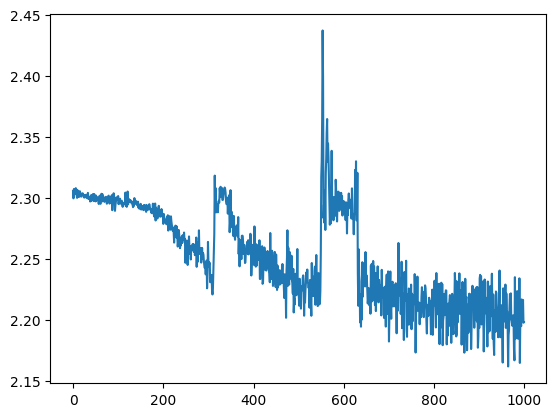

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
@eqx.filter_jit
def compute_accuracy(model, x, y):
    pred_y = jax.vmap(model)(x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)

avg_loss = 0
avg_acc = 0
for i in range(100):
    ix = jr.randint(jr.fold_in(key, i), (n_batch,), 0, n_data)
    x, y = X[ix], Y[ix]
    avg_loss += loss(model, x, y)
    avg_acc += compute_accuracy(model, x, y)

n_test = (i + 1) * n_batch
print(avg_loss / n_test, avg_acc / n_test)

0.004347931 0.0003062547


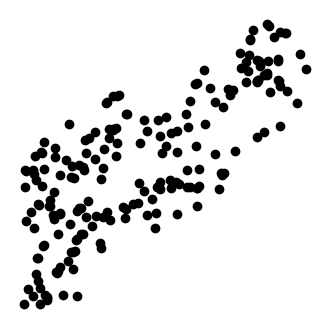

(5, 4)

In [ ]:
ix = np.random.randint(0, n_data)

plt.figure(figsize=(4., 4.))
plt.scatter(*X[ix].T, color="k")
plt.axis("off")
plt.show()

jnp.argmax(model(X[ix])).item(), Y[ix].item()